In [196]:
from pathlib import Path
import torch
import numpy as np
import pandas as pd
import sys
import os
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from src.model import Network
from src.utils import get_device
from src.dataset import GreyhoundDataset
import math

ImportError: cannot import name 'BATCH_SIZE' from 'src.dataset' (/Users/ellis/Git/greyhound-guesser/src/dataset.py)

In [197]:
N = 1000
batch_size = 64

In [71]:
def gen_test_data():
    odds_vals = [1, 2, 4, 8]
    dist_vals = [380, 560, 720]
    out = np.zeros((N, 19))
    out[:, 0] = 380 / 1000
    for i in range(6):
        ni = 3 * i
        out[:, 1 + ni] = 1 / np.random.choice(odds_vals, size=(N))
        out[:, 2 + ni] = np.random.choice(dist_vals, size=(N)) / 1000
        out[:, 3 + ni] = np.random.normal(loc=0.5, scale=0.25, size=(N)).clip(0, 1)
    return out

In [198]:
def load_test_data():
    os.chdir("..")
    dataset = GreyhoundDataset(device=get_device())
    os.chdir("eda")
    return dataset

In [199]:
data, labels = load_test_data()[:N]
data = data.cpu().numpy()
labels = labels.cpu().numpy()

In [200]:
data = gen_test_data()

In [201]:
device = get_device()
model_weights = "../models/gg-2023-11-10_10-20.pt"

In [202]:
model = Network()
model.load_state_dict(torch.load(model_weights, map_location=device))
model.to(device)

Network(
  (_layers): Sequential(
    (0): Linear(in_features=19, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=6, bias=True)
    (7): Softmax(dim=1)
  )
)

In [203]:
predictions = np.zeros((N, 6))
predictions_norm = np.zeros(N, dtype=np.int64)

In [204]:
for batch in range(N // batch_size):
    offset = batch * batch_size
    batch_data = torch.tensor(data[offset : offset + batch_size, :], device=device, dtype=torch.float32)
    predictions[offset : offset + batch_size, :] = model.forward(batch_data).detach().cpu().numpy()

In [205]:
traps = np.argmax(predictions, 1, predictions_norm)

In [206]:
to_concat = [data, traps.reshape(-1, 1)]
if "labels" in locals():
    to_concat.append(labels)
predictions = np.concatenate(to_concat, axis=1)

In [207]:
predictions[np.random.choice(range(predictions.shape[0]), size=(5)), :]

array([[0.38      , 0.25      , 0.56      , 0.71341863, 1.        ,
        0.72      , 0.36659163, 0.25      , 0.38      , 0.37478083,
        1.        , 0.38      , 0.80008265, 0.5       , 0.38      ,
        0.53287442, 1.        , 0.56      , 0.41059958, 3.        ,
        0.        , 1.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.38      , 0.125     , 0.38      , 0.25346546, 0.25      ,
        0.56      , 0.16739967, 0.25      , 0.38      , 0.79249975,
        1.        , 0.38      , 0.26575095, 0.125     , 0.72      ,
        0.36404045, 0.25      , 0.38      , 0.28550313, 3.        ,
        0.        , 0.        , 1.        , 0.        , 0.        ,
        0.        ],
       [0.38      , 0.5       , 0.38      , 0.21785586, 0.25      ,
        0.38      , 0.61363467, 1.        , 0.38      , 0.76413091,
        0.5       , 0.56      , 0.67932637, 1.        , 0.72      ,
        0.40379059, 0.5       , 0.38      , 0.3695611 , 4.        ,
      

In [208]:
def print_info(record):
    for dog in range(6):
        odds = 1 / record[1+3*dog]
        dist = 1000 * record[2+3*dog]
        fini = 6 - (5 * record[3+3*dog])
        
        print(f"Dog {dog+1}: Odds {round(odds)}, Distance {round(dist)}, Finish {round(fini)}")
    print(f"Predicted winner: {record[19]+1:.0f}")
    if record.shape[0] > 21:
        print(f"Actual winner: {record[20]+1:.0f}")

In [209]:
print_info(predictions[1, :])

Dog 1: Odds 4, Distance 380, Finish 5
Dog 2: Odds 2, Distance 380, Finish 3
Dog 3: Odds 2, Distance 560, Finish 6
Dog 4: Odds 2, Distance 720, Finish 5
Dog 5: Odds 2, Distance 720, Finish 2
Dog 6: Odds 4, Distance 720, Finish 3
Predicted winner: 1
Actual winner: 1


In [232]:
print_info(predictions[np.random.choice(range(predictions.shape[0]), size=(1)), :][0, :])

Dog 1: Odds 1, Distance 720, Finish 6
Dog 2: Odds 4, Distance 380, Finish 4
Dog 3: Odds 8, Distance 380, Finish 2
Dog 4: Odds 2, Distance 720, Finish 4
Dog 5: Odds 1, Distance 560, Finish 3
Dog 6: Odds 2, Distance 380, Finish 1
Predicted winner: 1
Actual winner: 1


In [176]:
diff = predictions[:, 19] == predictions[:, 20]

<Axes: ylabel='Frequency'>

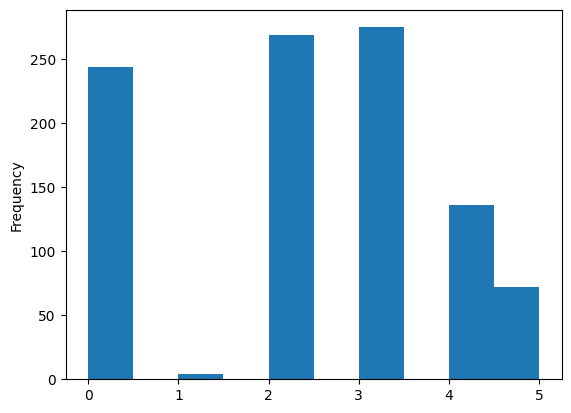

In [235]:
pd.Series(predictions[:, 19]).plot.hist()

<Axes: ylabel='Frequency'>

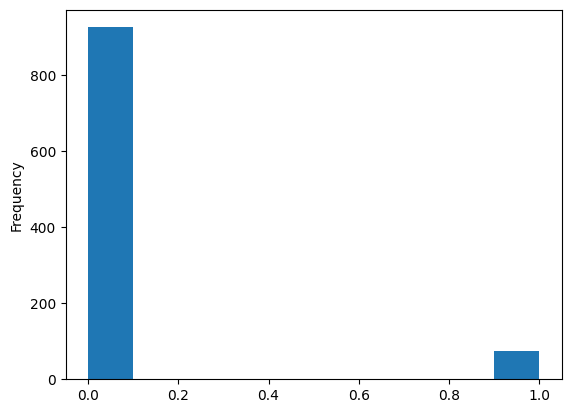

In [188]:
pd.Series(diff.astype(int)).plot.hist()

In [190]:
len(diff[diff == 1]) / len(diff) * 100

7.5